# Import and load data

In [2]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer #
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords #
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# make sure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('final_bbc_data.csv', index_col = 0)
print(df.shape)
df.head()

(900, 2)


,Ingredients,Cuisine
0,1 ½kg chicken thighs and drumsticks 180g sea s...,1
1,"1 large chicken 5 beef short ribs (about 3kg),...",1
2,"150g unsalted butter , softened 80g golden cas...",1
3,"1 whole chicken , jointed, or 8 bone-in chicke...",1
4,500g macaroni 1l whole milk 2 bay leaves 60g b...,1


In [ ]:
plt.figure(figsize=(10,4))
xx['type'].value_counts().plot(kind='bar', color='magenta')

# Cleaning

First, I'll start with a light cleaning of the corpus. I want to not only make sure all letters are lower case, but also remove all punctuation and numbers.

In [4]:
# create a function to lightly clean the corpus
def shallow_cleaning(_corpus):
    _corpus = _corpus.lower() # apply lowercase
    _corpus = re.sub('\[.*/()]', '', _corpus) # removes data-types in brackets
    _corpus = re.sub('[%s]' % re.escape(string.punctuation), '', _corpus) # list of punctuation, get rid of any punctuation in that list
    _corpus = re.sub('\w*\d\w*', '', _corpus) # removes all numbers and any words that contain them
    return _corpus
# apply the function and assign to variable
shallow_clean = lambda x: shallow_cleaning(x)

In [5]:
# apply the function to the ingredients column of the overall dataframe
shallow_ingredients = pd.DataFrame(df['Ingredients'].apply(shallow_clean))

# join lightly cleaned ingredients column with cuisines column
shallow_df = shallow_ingredients.join(df['Cuisine'])
shallow_df.head()

,Ingredients,Cuisine
0,½kg chicken thighs and drumsticks sea salt f...,1
1,large chicken beef short ribs about ribs se...,1
2,unsalted butter softened golden caster suga...,1
3,whole chicken jointed or bonein chicken pie...,1
4,macaroni whole milk bay leaves butter pla...,1


If we inspect our light changes, we can see that some ingredients still contain unnecessary words and characters like "½kg" and "or". we can remove these characters using the English stop words from the Natural Language Tools Kit library.
But first, the data needs to be cleaned even more. To do this, I will create a function that will tokenize the data, separate the characters to clean out the unnecessary ones, then rejoin the data back to it's original state, sans extra words and characters.

In [6]:
# use regex for deep cleaning
def deep_cleaning(_corpus):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+') # instantiate tokenizer to remove all non-english letters and non-whole numbers
    tokenized_corpus = tokenizer.tokenize(_corpus) # apply tokenizer to corpus
    n_corpus = ' '.join(tokenized_corpus) # rejoin tokenized corpus
    return n_corpus
# apply the function and assign to variable
deep_clean = lambda x: deep_cleaning(x)

In [7]:
deep_ingredients = pd.DataFrame(shallow_df['Ingredients'].apply(deep_clean))
deep_df = deep_ingredients.join(df['Cuisine'])

Now we can focus on removing unnecessary words or words that serve no real purpose to the overall meaning of the recipe ingredients.

In [8]:
# function to remove nltk designated stop words from the English language
def nltk_stopwords(string):
    stop_words = set(stopwords.words('english'))
    tokenized_string = tokenizer.tokenize(string)
    cleaned_string = [word for word in tokenized_string if word not in stop_words]
    new_str = ' '.join(cleaned_string)
    return new_str

remove_nltks = lambda x: nltk_stopwords(x)

def custom_stopwords(string):
    custom_stop_words = ['oz', 'lb', 'lbs', 'g', 'kg', 'gram', 'grams', 'cm', 'inch', 'ounce', 'pound', 'tsp', 'tbsp', 'small', 'medium', 'large']
    tokenized_string = tokenizer.tokenize(string)
    cleaned_string = [word for word in tokenized_string if word not in custom_stop_words]
    new_str = ' '.join(cleaned_string)
    return new_str 

remove_customs = lambda x: custom_stopwords(x)

I want to take a closer look at two specific ingredients to make sure our functions work. From *index 0* and *index 3*, I will keep and eye on "kg" and "or", respectively.

In [9]:
# look at ingredietns
print(deep_df[deep_df.index == 0])
print(deep_df[deep_df.index == 3]) 

                                         Ingredients  Cuisine
0  kg chicken thighs and drumsticks sea salt flak...        1
                                         Ingredients  Cuisine
3  whole chicken jointed or bonein chicken pieces...        1


In [10]:
# apply fuctions and rejoin dataframe
custom_ings = pd.DataFrame(deep_df['Ingredients'].apply(remove_customs))
rmv_custom_df = custom_ings.join(df['Cuisine'])

nltk_ings = pd.DataFrame(rmv_custom_df['Ingredients'].apply(remove_nltks))
df2 = nltk_ings.join(df['Cuisine'])

In [11]:
# check custom_stopwords fuction
print(df2[df2.index == 0]) # "kg" from index 0

# check nltk_stopwords function
print(df2[df2.index == 3]) # "or" from index 3

                                         Ingredients  Cuisine
0  chicken thighs drumsticks sea salt flakes soft...        1
                                         Ingredients  Cuisine
3  whole chicken jointed bonein chicken pieces us...        1


The functions work!

Now let's see if there are any more words we can remove. We'll do this by using a word cloud of all the ingredients featured in the dataset.

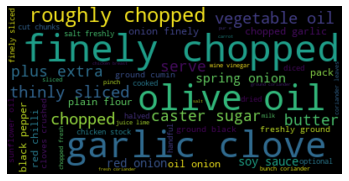

In [12]:
full_ings_lst = [x for x in df2['Ingredients']]
full_ings_str = ' '.join(full_ings_lst)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words = 50).generate(full_ings_str)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the word cloud generated above, we can see that the most commonly used words seem to be unspecific adjectives like "finely" and "roughly" as well as random ingredients like "olive" and "clove". This is useful information to a degree, however the flaw is that when we have the existence of ingredients like "olive oil", our model may struggle to distinguish similar nouns like "olive" and "oil". 

To help fix this issue, we will need to incorporate the use of bigrams to find any more words we deem unless or detrimental to the model. This is an iterative process that will require tuning. 

In [13]:
ingredients = [x for x in df2['Ingredients']]

# tokenize ingredients
ing_tokes = [tokenizer.tokenize(i) for i in ingredients] 

In [14]:
from nltk import word_tokenize 
from nltk.util import ngrams

ing_bigrams = []
for i in ing_tokes:
    ing_bigrams.append(list(ngrams(i, 2)))
    
bigram_df = []
for i in ing_bigrams:
    bigram_df.append(list(map(' '.join, i)))
    
big_df = [bigram_df_lst for bigram_lst_df in bigram_df for bigram_df_lst in bigram_lst_df]
big_df

['chicken thighs',
 'thighs drumsticks',
 'drumsticks sea',
 'sea salt',
 'salt flakes',
 'flakes soft',
 'soft dark',
 'dark brown',
 'brown sugar',
 'sugar chilli',
 'chilli flakes',
 'flakes sweet',
 'sweet smoked',
 'smoked paprika',
 'paprika ground',
 'ground cumin',
 'cumin sea',
 'sea salt',
 'salt flakes',
 'flakes dark',
 'dark brown',
 'brown sugar',
 'sugar butter',
 'butter hot',
 'hot chilli',
 'chilli sauce',
 'sauce maple',
 'maple syrup',
 'chicken beef',
 'beef short',
 'short ribs',
 'ribs ribs',
 'ribs separated',
 'separated piece',
 'piece boned',
 'boned pork',
 'pork shoulder',
 'shoulder rind',
 'rind removed',
 'removed texas',
 'texas barbecue',
 'barbecue sauce',
 'sauce sliced',
 'sliced sweet',
 'sweet white',
 'white onions',
 'onions sliced',
 'sliced gherkins',
 'gherkins serve',
 'serve goodquality',
 'goodquality flaky',
 'flaky sea',
 'sea salt',
 'salt fennel',
 'fennel seeds',
 'seeds black',
 'black peppercorns',
 'peppercorns bay',
 'bay leaves',

In [15]:
# function to plot top n most common words 
def plot_fdist(grp_of_wds, n):
    fdist = FreqDist(grp_of_wds)
    plt.figure(figsize=(10, 10))
    return fdist.plot(n)

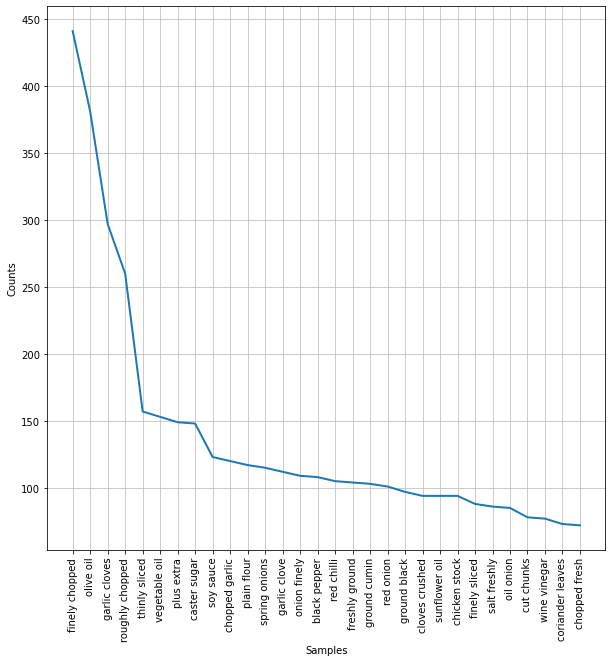

In [16]:
# check word distribution of top 20 words
plot_fdist(big_df, 30)

In [57]:
ing_tokes

[['chicken',
  'thighs',
  'drumsticks',
  'sea',
  'salt',
  'flakes',
  'soft',
  'dark',
  'brown',
  'sugar',
  'chilli',
  'flakes',
  'sweet',
  'smoked',
  'paprika',
  'ground',
  'cumin',
  'sea',
  'salt',
  'flakes',
  'dark',
  'brown',
  'sugar',
  'butter',
  'hot',
  'chilli',
  'sauce',
  'maple',
  'syrup'],
 ['chicken',
  'beef',
  'short',
  'ribs',
  'ribs',
  'separated',
  'piece',
  'boned',
  'pork',
  'shoulder',
  'rind',
  'removed',
  'texas',
  'barbecue',
  'sauce',
  'sliced',
  'sweet',
  'white',
  'onions',
  'sliced',
  'gherkins',
  'serve',
  'goodquality',
  'flaky',
  'sea',
  'salt',
  'fennel',
  'seeds',
  'black',
  'peppercorns',
  'bay',
  'leaves',
  'cayenne',
  'pepper',
  'smoked',
  'paprika',
  'garlic',
  'salt',
  'soft',
  'light',
  'brown',
  'sugar',
  'golden',
  'caster',
  'sugar',
  'wood',
  'chips',
  'optional'],
 ['unsalted',
  'butter',
  'softened',
  'golden',
  'caster',
  'sugar',
  'egg',
  'yolks',
  'lightly',
  '

In [23]:
# Stemming: change = chang
from nltk.stem import PorterStemmer
ps = PorterStemmer()

stemmed_ingredients = []
for ingredients in ing_tokes:
    for ingredient in ingredients:
        stemmed_ingredients.append(ps.stem(ingredient))

print(stemmed_ingredients)

['chicken', 'thigh', 'drumstick', 'sea', 'salt', 'flake', 'soft', 'dark', 'brown', 'sugar', 'chilli', 'flake', 'sweet', 'smoke', 'paprika', 'ground', 'cumin', 'sea', 'salt', 'flake', 'dark', 'brown', 'sugar', 'butter', 'hot', 'chilli', 'sauc', 'mapl', 'syrup', 'chicken', 'beef', 'short', 'rib', 'rib', 'separ', 'piec', 'bone', 'pork', 'shoulder', 'rind', 'remov', 'texa', 'barbecu', 'sauc', 'slice', 'sweet', 'white', 'onion', 'slice', 'gherkin', 'serv', 'goodqual', 'flaki', 'sea', 'salt', 'fennel', 'seed', 'black', 'peppercorn', 'bay', 'leav', 'cayenn', 'pepper', 'smoke', 'paprika', 'garlic', 'salt', 'soft', 'light', 'brown', 'sugar', 'golden', 'caster', 'sugar', 'wood', 'chip', 'option', 'unsalt', 'butter', 'soften', 'golden', 'caster', 'sugar', 'egg', 'yolk', 'lightli', 'beaten', 'plain', 'flour', 'plu', 'extra', 'dust', 'pecan', 'toast', 'egg', 'golden', 'caster', 'sugar', 'golden', 'syrup', 'unsalt', 'butter', 'melt', 'sea', 'salt', 'plu', 'extra', 'sprinkl', 'vanilla', 'extract', 'b

In [49]:
# lemmatezization: changer = change
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

lemmatized_ingredients = []

for ingredients in ing_tokes:
    lemmed = ' '.join([lemmatizer.lemmatize(x) for x in ingredients])
    lemmatized_ingredients.append(lemmed)
lemmatized_ingredients

['chicken thigh drumstick sea salt flake soft dark brown sugar chilli flake sweet smoked paprika ground cumin sea salt flake dark brown sugar butter hot chilli sauce maple syrup',
 'chicken beef short rib rib separated piece boned pork shoulder rind removed texas barbecue sauce sliced sweet white onion sliced gherkin serve goodquality flaky sea salt fennel seed black peppercorn bay leaf cayenne pepper smoked paprika garlic salt soft light brown sugar golden caster sugar wood chip optional',
 'unsalted butter softened golden caster sugar egg yolk lightly beaten plain flour plus extra dusting pecan toasted egg golden caster sugar golden syrup unsalted butter melted sea salt plus extra sprinkling vanilla extract bourbon whisky optional double cream maple syrup',
 'whole chicken jointed bonein chicken piece used leg breast thigh wing sea salt smoked paprika garlic granule runny honey cider vinegar light brown soft sugar american mustard',
 'macaroni whole milk bay leaf butter plain flour d

In [50]:
lemmatized_ingredients[0]

'chicken thigh drumstick sea salt flake soft dark brown sugar chilli flake sweet smoked paprika ground cumin sea salt flake dark brown sugar butter hot chilli sauce maple syrup'

# Modeling

In [56]:
import pickle 

more_words = ['finely', 'chopped', 'roughly', 'thinly', 'sliced', 'serve', 'optional', 'pack', 'plus', 'youre', 'youve']

pickle.dump(more_words, open( "more_words.pickle", "wb" ) )

## Bag Of Words
Do not need to tokenize the document. 

Makes the assumption that documents that get classified together share similar tokens and token frequency. However, the problem is semantic meaning is not captured and commonly occurring words may end up not being very helpful. 

In [31]:
# jujst create the countvecotizer and pass in parameters
vec = CountVectorizer(stop_words= more_words, ngram_range = (1,2)) #give me unigram and end with bigram
X = vec.fit_transform(df2['Ingredients'])


df2_dtm = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df2_dtm

,aberdeen,aberdeen angus,absorbing,absorbing liquid,according,according instructions,according packet,according taste,action,action yeast,...,zest unwaxed,zest wedges,zested,zested ball,zested cut,zested filo,zested garlic,zested good,zested juiced,zested squeeze
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# look at unique features
vec.get_feature_names()

['aberdeen',
 'aberdeen angus',
 'absorbing',
 'absorbing liquid',
 'according',
 'according instructions',
 'according packet',
 'according taste',
 'action',
 'action yeast',
 'adam',
 'adam pearmain',
 'add',
 'add colour',
 'add extra',
 'add thumbnailsized',
 'african',
 'african spice',
 'african stores',
 'airdried',
 'airdried ham',
 'ale',
 'ale beef',
 'ale freerange',
 'allbutter',
 'allbutter puff',
 'allspice',
 'allspice bags',
 'allspice basmati',
 'allspice berries',
 'allspice bunch',
 'allspice cans',
 'allspice fresh',
 'allspice ground',
 'allspice nutmeg',
 'allspice peppercorns',
 'allspice plum',
 'allspice salt',
 'allspice single',
 'allspice split',
 'allspice sunflower',
 'allspice white',
 'almond',
 'almond bunch',
 'almond essence',
 'almond extra',
 'almond extract',
 'almond golden',
 'almond handful',
 'almond icing',
 'almond light',
 'almond lowfat',
 'almond milk',
 'almond preserved',
 'almond raisin',
 'almond single',
 'almond thins',
 'almond toa

In [36]:
X
print(X)

  (0, 1827)	1
  (0, 13404)	1
  (0, 4006)	1
  (0, 11383)	2
  (0, 11090)	2
  (0, 4601)	3
  (0, 12189)	1
  (0, 3473)	2
  (0, 1205)	2
  (0, 12910)	2
  (0, 1896)	2
  (0, 13138)	1
  (0, 12111)	1
  (0, 8823)	1
  (0, 5538)	1
  (0, 3321)	1
  (0, 1327)	1
  (0, 6030)	1
  (0, 11185)	1
  (0, 7325)	1
  (0, 13171)	1
  (0, 1861)	1
  (0, 13411)	1
  (0, 4010)	1
  (0, 11388)	2
  :	:
  (899, 3365)	1
  (899, 4862)	1
  (899, 8618)	1
  (899, 6662)	1
  (899, 13529)	1
  (899, 10828)	1
  (899, 3162)	1
  (899, 8840)	1
  (899, 1571)	1
  (899, 8657)	1
  (899, 8650)	1
  (899, 14437)	1
  (899, 10027)	1
  (899, 7368)	1
  (899, 6628)	1
  (899, 1572)	1
  (899, 1201)	1
  (899, 12094)	1
  (899, 8658)	1
  (899, 3195)	1
  (899, 13693)	1
  (899, 4674)	1
  (899, 13530)	1
  (899, 11094)	1
  (899, 7379)	1


In [35]:
pd.DataFrame(X)

,0
0,"(0, 1827)\t1\n (0, 13404)\t1\n (0, 4006)\t..."
1,"(0, 1827)\t1\n (0, 11383)\t1\n (0, 11090)\..."
2,"(0, 11383)\t1\n (0, 11090)\t1\n (0, 12910)..."
3,"(0, 1827)\t2\n (0, 13404)\t1\n (0, 11383)\..."
4,"(0, 1327)\t1\n (0, 14584)\t1\n (0, 542)\t1..."
...,...
895,"(0, 11090)\t1\n (0, 1896)\t1\n (0, 1327)\t..."
896,"(0, 11090)\t1\n (0, 5538)\t2\n (0, 3321)\t..."
897,"(0, 12189)\t1\n (0, 1205)\t2\n (0, 12910)\..."
898,"(0, 11090)\t1\n (0, 1896)\t2\n (0, 8558)\t..."


In [37]:
df_vec = pd.DataFrame(X.todense(),columns = vec.get_feature_names())
df_vec

,aberdeen,aberdeen angus,absorbing,absorbing liquid,according,according instructions,according packet,according taste,action,action yeast,...,zest unwaxed,zest wedges,zested,zested ball,zested cut,zested filo,zested garlic,zested good,zested juiced,zested squeeze
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF
Frequency of a word in a document.

In [41]:
# remove stop words by setting stop words = to stopwords
tf=TfidfVectorizer()
ing_tf= tf.fit_transform(df2['Ingredients'])
ing_tf.data

array([0.19078157, 0.21107094, 0.10279776, ..., 0.10348449, 0.07248442,
       0.15903434])

In [44]:
# define features and target
data = df2['Ingredients']
target = df2['Cuisine']

In [53]:
X_lem = lemmatized_ingredients

y_lem = target

Always TTS first, then apply the vectorizer in order to ensure that the testing data has not been seen by the model.

In [54]:
# split first
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem) #fit vectorizor then transform
tfidf_data_test_lem = tfidf.transform(X_test_lem) # only need to transform test data

tfidf_data_train_lem

<720x1612 sparse matrix of type '<class 'numpy.float64'>'
	with 22836 stored elements in Compressed Sparse Row format>

In [ ]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

In [ ]:
p_labels = pred_labels(preds,.5)

test_labels = test_generator.labels

cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: CNN')
plt.show()

print(classification_report(test_labels, p_labels))